# NN-based Word Vectorizing

In [1]:
import numpy as np

## One-Hot Encoding for each Words

In [2]:
c = np.array([[1, 0, 0, 0, 0, 0, 0]])   # one-hot encoding input : 1 x 7
W = np.random.randn(7, 3)   # weight matrix : 7 x 3
h = np.dot(c, W)
print(h)

[[-1.23238634 -0.88965786 -1.43763126]]


Forwarding in Matmul.

In [3]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

In [4]:
c = np.array([[1, 0, 0, 0, 0, 0, 0]])   # one-hot encoding input : 1 x 7
W = np.random.randn(7,3)
matmul_layer = MatMul(W)
h = matmul_layer.forward(c)
print(h)

[[-0.87639797 -0.67168903  1.49635591]]


# Continuous Bag-of-Words (CBOW)

The following is the inference demo. We don't use activation function, use no bias based `MatMul` function, use multiple inputs for the context and use the same weighting values in the same layer.

In [5]:
# sample for context
# multiple inputs
c0 = np.array([1, 0, 0, 0, 0, 0, 0])
c1 = np.array([0, 0, 1, 0, 0, 0, 0])

# initial weights (shared or same in the same layer)
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

# construct each layers
in_layer0 = MatMul(W_in)   # for c0
in_layer1 = MatMul(W_in)   # for c1
out_layer = MatMul(W_out)  # scoring

# forward
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = (0.5) * (h0 + h1)
s = out_layer.forward(h)

print(s)

[-1.48080202  0.59958551  2.72965534 -0.39745546 -1.31836537 -1.13304715
  0.82621832]


## Data Processing

In [6]:
import os, sys

In [7]:
sys.path.append(os.path.join(".","common"))

In [8]:
from util import preprocess

In [9]:
text = "You say goodbye and I say hello."

In [10]:
corpus, word_to_id, id_to_word = preprocess(text)

In [11]:
print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [12]:
def create_contexts_target(corpus, window_size=1):
    text_length = len(corpus)
    contexts = []
    target = []
    
    for order in range(window_size, text_length-window_size, 1):
        context_tmp = []
        target += [corpus[order]]
        
        for idx in range(0, window_size+1):
            if idx == 0: continue
            left_order = order - idx
            right_order = order + idx
            
            if left_order >= 0:
                context_tmp = [corpus[left_order]] + context_tmp
            
            if right_order < text_length:
                context_tmp = context_tmp + [corpus[right_order]]
        
        contexts.append(context_tmp)
                
    return np.array(contexts), np.array(target)

In [13]:
contexts, target = create_contexts_target(corpus=corpus, window_size=1)

In [14]:
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [15]:
def convert_one_hot(m, vocab_size):
    one_hot_m = None
    if m.ndim == 1:
        one_hot_m = np.zeros((m.shape[0],) + (vocab_size,), dtype=np.int32)
        one_hot_m[np.arange(m.shape[0]), m] = 1
    elif m.ndim == 2:
        rn, cn = m.shape
        one_hot_m = np.zeros((rn, cn, vocab_size), dtype=np.int32)
        for r in range(rn):
            for c in range(cn):
                one_hot_m[r, c, m[r,c]] = 1
    return one_hot_m

In [16]:
convert_one_hot(np.array([1,2,5]), 7)

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [17]:
convert_one_hot(np.array([[1,2],[3,4]]), 7)

array([[[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]]], dtype=int32)

In [18]:
contexts = convert_one_hot(contexts, vocab_size=len(word_to_id))
target = convert_one_hot(target, vocab_size=len(word_to_id))

In [19]:
print(contexts)
print(target)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


## SimpleCBOW

In [20]:
from layers import SoftmaxWithLoss
from methods import softmax

In [21]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # initialize weights
        W_in = 1e-2 * np.random.randn(vocab_size, hidden_size).astype('f')
        W_out = 1e-2 * np.random.randn(hidden_size, vocab_size).astype('f')
        
        # initialize layers
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # grads and params
        self.params, self.grads = [], []
        layers = [self.in_layer0, self.in_layer1, self.out_layer, self.out_layer]
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector
        self.word_vec = W_in
    
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:,0])
        h1 = self.in_layer1.forward(contexts[:,1])
        h = (0.5) * (h0 + h1)
        s = self.out_layer.forward(h)
        loss = self.loss_layer.forward(s, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer0.backward(da)
        self.in_layer1.backward(da)
        return None
    
    def predict(self, contexts, id_to_word):
        h0 = self.in_layer0.forward(contexts[:,0])
        h1 = self.in_layer1.forward(contexts[:,1])
        h = (0.5) * (h0 + h1)
        s = self.out_layer.forward(h)
        p = softmax(s)
        
        for data_idx in range(contexts.shape[0]):
            for idx in (-p[data_idx]).argsort():
                print("Prob {:3f}: {}".format(p[data_idx][idx], id_to_word[idx]))

        return p

## Training

In [22]:
from optimizer import Adam
from trainer import Trainer

In [23]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

In [24]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

In [25]:
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus=corpus, window_size=window_size)
contexts = convert_one_hot(contexts, vocab_size=vocab_size)
target = convert_one_hot(target, vocab_size=vocab_size)

In [26]:
model = SimpleCBOW(vocab_size, hidden_size)
adam_opt = Adam()

In [27]:
trainer = Trainer(model, adam_opt)

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 223 |  iter 1 / 2 | time 0[s] | loss 1.23
| epoch 224 |  iter 1 / 2 | time 0[s] | loss 1.10
| epoch 225 |  iter 1 / 2 | time 0[s] | loss 1.15
| epoch 226 |  iter 1 / 2 | time 0[s] | loss 1.09
| epoch 227 |  iter 1 / 2 | time 0[s] | loss 1.20
| epoch 228 |  iter 1 / 2 | time 0[s] | loss 1.10
| epoch 229 |  iter 1 / 2 | time 0[s] | loss 1.21
| epoch 230 |  iter 1 / 2 | time 0[s] | loss 1.19
| epoch 231 |  iter 1 / 2 | time 0[s] | loss 1.08
| epoch 232 |  iter 1 / 2 | time 0[s] | loss 1.11
| epoch 233 |  iter 1 / 2 | time 0[s] | loss 1.13
| epoch 234 |  iter 1 / 2 | time 0[s] | loss 1.14
| epoch 235 |  iter 1 / 2 | time 0[s] | loss 1.05
| epoch 236 |  iter 1 / 2 | time 0[s] | loss 1.12
| epoch 237 |  iter 1 / 2 | time 0[s] | loss 1.19
| epoch 238 |  iter 1 / 2 | time 0[s] | loss 1.12
| epoch 239 |  iter 1 / 2 | time 0[s] | loss 1.10
| epoch 240 |  iter 1 / 2 | time 0[s] | loss 1.11
| epoch 241 |  iter 1 / 2 | time 0[s] | loss 1.10
| epoch 242 |  iter 1 / 2 | time 0[s] | loss 1.09


| epoch 448 |  iter 1 / 2 | time 0[s] | loss 0.77
| epoch 449 |  iter 1 / 2 | time 0[s] | loss 0.76
| epoch 450 |  iter 1 / 2 | time 0[s] | loss 0.71
| epoch 451 |  iter 1 / 2 | time 0[s] | loss 0.71
| epoch 452 |  iter 1 / 2 | time 0[s] | loss 0.67
| epoch 453 |  iter 1 / 2 | time 0[s] | loss 0.75
| epoch 454 |  iter 1 / 2 | time 0[s] | loss 0.61
| epoch 455 |  iter 1 / 2 | time 0[s] | loss 0.76
| epoch 456 |  iter 1 / 2 | time 0[s] | loss 0.80
| epoch 457 |  iter 1 / 2 | time 0[s] | loss 0.61
| epoch 458 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 459 |  iter 1 / 2 | time 0[s] | loss 0.75
| epoch 460 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 461 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 462 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 463 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 464 |  iter 1 / 2 | time 0[s] | loss 0.74
| epoch 465 |  iter 1 / 2 | time 0[s] | loss 0.74
| epoch 466 |  iter 1 / 2 | time 0[s] | loss 0.60
| epoch 467 |  iter 1 / 2 | time 0[s] | loss 0.74


| epoch 683 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 684 |  iter 1 / 2 | time 0[s] | loss 0.39
| epoch 685 |  iter 1 / 2 | time 0[s] | loss 0.57
| epoch 686 |  iter 1 / 2 | time 0[s] | loss 0.44
| epoch 687 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 688 |  iter 1 / 2 | time 0[s] | loss 0.38
| epoch 689 |  iter 1 / 2 | time 0[s] | loss 0.54
| epoch 690 |  iter 1 / 2 | time 0[s] | loss 0.37
| epoch 691 |  iter 1 / 2 | time 0[s] | loss 0.47
| epoch 692 |  iter 1 / 2 | time 0[s] | loss 0.38
| epoch 693 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 694 |  iter 1 / 2 | time 0[s] | loss 0.51
| epoch 695 |  iter 1 / 2 | time 0[s] | loss 0.43
| epoch 696 |  iter 1 / 2 | time 0[s] | loss 0.46
| epoch 697 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 698 |  iter 1 / 2 | time 0[s] | loss 0.27
| epoch 699 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 700 |  iter 1 / 2 | time 0[s] | loss 0.51
| epoch 701 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 702 |  iter 1 / 2 | time 0[s] | loss 0.41


| epoch 916 |  iter 1 / 2 | time 0[s] | loss 0.27
| epoch 917 |  iter 1 / 2 | time 0[s] | loss 0.45
| epoch 918 |  iter 1 / 2 | time 0[s] | loss 0.38
| epoch 919 |  iter 1 / 2 | time 0[s] | loss 0.36
| epoch 920 |  iter 1 / 2 | time 0[s] | loss 0.36
| epoch 921 |  iter 1 / 2 | time 0[s] | loss 0.34
| epoch 922 |  iter 1 / 2 | time 0[s] | loss 0.47
| epoch 923 |  iter 1 / 2 | time 0[s] | loss 0.37
| epoch 924 |  iter 1 / 2 | time 0[s] | loss 0.14
| epoch 925 |  iter 1 / 2 | time 0[s] | loss 0.44
| epoch 926 |  iter 1 / 2 | time 0[s] | loss 0.25
| epoch 927 |  iter 1 / 2 | time 0[s] | loss 0.46
| epoch 928 |  iter 1 / 2 | time 0[s] | loss 0.25
| epoch 929 |  iter 1 / 2 | time 0[s] | loss 0.46
| epoch 930 |  iter 1 / 2 | time 0[s] | loss 0.46
| epoch 931 |  iter 1 / 2 | time 0[s] | loss 0.16
| epoch 932 |  iter 1 / 2 | time 0[s] | loss 0.35
| epoch 933 |  iter 1 / 2 | time 0[s] | loss 0.44
| epoch 934 |  iter 1 / 2 | time 0[s] | loss 0.35
| epoch 935 |  iter 1 / 2 | time 0[s] | loss 0.35


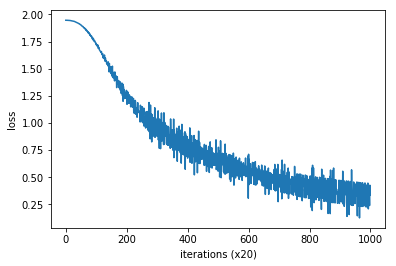

In [28]:
trainer.fit(contexts, target, max_epoch=max_epoch, batch_size=batch_size)
trainer.plot()

## Prediction

In [29]:
p = model.predict(contexts[:1], id_to_word)

Prob 0.908611: say
Prob 0.078830: and
Prob 0.004372: .
Prob 0.004348: you
Prob 0.001876: i
Prob 0.001868: goodbye
Prob 0.000096: hello


## Word Vector

In [30]:
word_vecs = model.word_vec

In [31]:
for word, word_id in word_to_id.items():
    print(word, word_vecs[word_id])

you [ 0.96811426 -0.9448326   0.9322287  -1.6503654   0.6360321 ]
say [-1.154661   1.1443766 -1.1244701 -0.4149236 -1.2067703]
goodbye [ 1.0572071  -1.0298079   1.0820192   0.42040908  1.1755956 ]
and [-0.6107772   0.7436572  -0.7766949  -1.7885811  -0.82036084]
i [ 1.037381   -1.0121878   1.0824977   0.43073088  1.1811774 ]
hello [ 0.9272935 -0.9463897  0.9593051 -1.6657768  0.6425327]
. [-1.2945675  1.1753086 -1.2107428  1.6267432 -1.2162405]


# Skip-gram

In [32]:
window_size = 1
hidden_size = 5
batch_size = 4
max_epoch = 1000

In [33]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

In [34]:
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus=corpus, window_size=window_size)
skipgram_target = convert_one_hot(contexts, vocab_size=vocab_size)
skipgram_contexts = convert_one_hot(target, vocab_size=vocab_size)

In [35]:
class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # initialize weights
        W_in = 0.01 * np.random.randn(V, H)
        W_out = 0.01 * np.random.randn(H, V)
        
        # initialize layers
        self.in_layer = MatMul(W_in)
        self.out_layer0 = MatMul(W_out)
        self.out_layer1 = MatMul(W_out)
        self.loss_layer0 = SoftmaxWithLoss()
        self.loss_layer1 = SoftmaxWithLoss()
        
        # get all params and grads
        self.params, self.grads = [], []
        layers = [self.in_layer, self.out_layer0, self.out_layer1]
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector
        self.word_vec = W_in
    
    def forward(self, contexts, target):
        h = self.in_layer.forward(contexts)
        s1 = self.out_layer0.forward(h)
        s2 = self.out_layer1.forward(h)
        loss1 = self.loss_layer0.forward(s1, target[:,0])
        loss2 = self.loss_layer1.forward(s2, target[:,1])
        total_loss = loss1 + loss2
        return total_loss
    
    def backward(self, dout=1):
        da0 = self.loss_layer0.backward(dout)
        da1 = self.loss_layer1.backward(dout)
        dx0 = self.out_layer0.backward(da0)
        dx1 = self.out_layer1.backward(da1)
        dW_in = self.in_layer.backward(dx0 + dx1)
        return None
    
    def predict(self, contexts, id_to_word):
        h = self.in_layer.forward(contexts)
        s1 = self.out_layer0.forward(h)
        s2 = self.out_layer1.forward(h)
        
        for context_idx in range(contexts.shape[0]):
            idx, = np.where(contexts[context_idx] == 1)
            print("[word : {}]".format(id_to_word[idx[0]]))
            
            for idx in (-s1[context_idx]).argsort():
                print("Upstream word: {}".format(id_to_word[idx]))
                break

            for idx in (-s2[context_idx]).argsort():
                print("Downstream word: {}".format(id_to_word[idx]))
                break

In [36]:
skipgram_model = SimpleSkipGram(vocab_size=vocab_size, hidden_size=hidden_size)
optimizer = Adam()

In [37]:
trainer = Trainer(skipgram_model, optimizer)

| epoch 1 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 2 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 3 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 4 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 5 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 6 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 7 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 8 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 9 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 10 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 11 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 12 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 13 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 14 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 15 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 16 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 17 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 18 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 19 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 20 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 21 |  iter 1 / 1 | ti

| epoch 227 |  iter 1 / 1 | time 0[s] | loss 3.22
| epoch 228 |  iter 1 / 1 | time 0[s] | loss 3.30
| epoch 229 |  iter 1 / 1 | time 0[s] | loss 3.21
| epoch 230 |  iter 1 / 1 | time 0[s] | loss 3.20
| epoch 231 |  iter 1 / 1 | time 0[s] | loss 3.29
| epoch 232 |  iter 1 / 1 | time 0[s] | loss 3.24
| epoch 233 |  iter 1 / 1 | time 0[s] | loss 3.23
| epoch 234 |  iter 1 / 1 | time 0[s] | loss 3.28
| epoch 235 |  iter 1 / 1 | time 0[s] | loss 3.22
| epoch 236 |  iter 1 / 1 | time 0[s] | loss 3.27
| epoch 237 |  iter 1 / 1 | time 0[s] | loss 3.27
| epoch 238 |  iter 1 / 1 | time 0[s] | loss 3.24
| epoch 239 |  iter 1 / 1 | time 0[s] | loss 3.23
| epoch 240 |  iter 1 / 1 | time 0[s] | loss 3.22
| epoch 241 |  iter 1 / 1 | time 0[s] | loss 3.19
| epoch 242 |  iter 1 / 1 | time 0[s] | loss 3.16
| epoch 243 |  iter 1 / 1 | time 0[s] | loss 3.13
| epoch 244 |  iter 1 / 1 | time 0[s] | loss 3.13
| epoch 245 |  iter 1 / 1 | time 0[s] | loss 3.18
| epoch 246 |  iter 1 / 1 | time 0[s] | loss 3.17


| epoch 401 |  iter 1 / 1 | time 0[s] | loss 2.77
| epoch 402 |  iter 1 / 1 | time 0[s] | loss 2.76
| epoch 403 |  iter 1 / 1 | time 0[s] | loss 2.64
| epoch 404 |  iter 1 / 1 | time 0[s] | loss 2.57
| epoch 405 |  iter 1 / 1 | time 0[s] | loss 2.75
| epoch 406 |  iter 1 / 1 | time 0[s] | loss 2.69
| epoch 407 |  iter 1 / 1 | time 0[s] | loss 2.63
| epoch 408 |  iter 1 / 1 | time 0[s] | loss 2.75
| epoch 409 |  iter 1 / 1 | time 0[s] | loss 2.63
| epoch 410 |  iter 1 / 1 | time 0[s] | loss 2.74
| epoch 411 |  iter 1 / 1 | time 0[s] | loss 2.75
| epoch 412 |  iter 1 / 1 | time 0[s] | loss 2.74
| epoch 413 |  iter 1 / 1 | time 0[s] | loss 2.60
| epoch 414 |  iter 1 / 1 | time 0[s] | loss 2.74
| epoch 415 |  iter 1 / 1 | time 0[s] | loss 2.80
| epoch 416 |  iter 1 / 1 | time 0[s] | loss 2.74
| epoch 417 |  iter 1 / 1 | time 0[s] | loss 2.74
| epoch 418 |  iter 1 / 1 | time 0[s] | loss 2.73
| epoch 419 |  iter 1 / 1 | time 0[s] | loss 2.73
| epoch 420 |  iter 1 / 1 | time 0[s] | loss 2.66


| epoch 648 |  iter 1 / 1 | time 0[s] | loss 2.58
| epoch 649 |  iter 1 / 1 | time 0[s] | loss 2.49
| epoch 650 |  iter 1 / 1 | time 0[s] | loss 2.38
| epoch 651 |  iter 1 / 1 | time 0[s] | loss 2.50
| epoch 652 |  iter 1 / 1 | time 0[s] | loss 2.37
| epoch 653 |  iter 1 / 1 | time 0[s] | loss 2.23
| epoch 654 |  iter 1 / 1 | time 0[s] | loss 2.39
| epoch 655 |  iter 1 / 1 | time 0[s] | loss 2.21
| epoch 656 |  iter 1 / 1 | time 0[s] | loss 2.40
| epoch 657 |  iter 1 / 1 | time 0[s] | loss 2.40
| epoch 658 |  iter 1 / 1 | time 0[s] | loss 2.49
| epoch 659 |  iter 1 / 1 | time 0[s] | loss 2.40
| epoch 660 |  iter 1 / 1 | time 0[s] | loss 2.39
| epoch 661 |  iter 1 / 1 | time 0[s] | loss 2.29
| epoch 662 |  iter 1 / 1 | time 0[s] | loss 2.49
| epoch 663 |  iter 1 / 1 | time 0[s] | loss 2.57
| epoch 664 |  iter 1 / 1 | time 0[s] | loss 2.39
| epoch 665 |  iter 1 / 1 | time 0[s] | loss 2.37
| epoch 666 |  iter 1 / 1 | time 0[s] | loss 2.38
| epoch 667 |  iter 1 / 1 | time 0[s] | loss 2.28


| epoch 862 |  iter 1 / 1 | time 0[s] | loss 2.23
| epoch 863 |  iter 1 / 1 | time 0[s] | loss 2.47
| epoch 864 |  iter 1 / 1 | time 0[s] | loss 2.22
| epoch 865 |  iter 1 / 1 | time 0[s] | loss 2.14
| epoch 866 |  iter 1 / 1 | time 0[s] | loss 2.23
| epoch 867 |  iter 1 / 1 | time 0[s] | loss 2.07
| epoch 868 |  iter 1 / 1 | time 0[s] | loss 2.08
| epoch 869 |  iter 1 / 1 | time 0[s] | loss 2.32
| epoch 870 |  iter 1 / 1 | time 0[s] | loss 2.22
| epoch 871 |  iter 1 / 1 | time 0[s] | loss 2.54
| epoch 872 |  iter 1 / 1 | time 0[s] | loss 2.39
| epoch 873 |  iter 1 / 1 | time 0[s] | loss 2.40
| epoch 874 |  iter 1 / 1 | time 0[s] | loss 2.39
| epoch 875 |  iter 1 / 1 | time 0[s] | loss 2.22
| epoch 876 |  iter 1 / 1 | time 0[s] | loss 2.22
| epoch 877 |  iter 1 / 1 | time 0[s] | loss 2.22
| epoch 878 |  iter 1 / 1 | time 0[s] | loss 2.46
| epoch 879 |  iter 1 / 1 | time 0[s] | loss 2.07
| epoch 880 |  iter 1 / 1 | time 0[s] | loss 2.14
| epoch 881 |  iter 1 / 1 | time 0[s] | loss 2.54


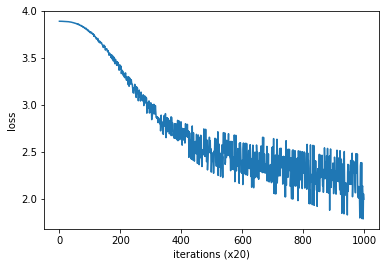

In [38]:
trainer.fit(skipgram_contexts, skipgram_target, max_epoch=max_epoch, batch_size=batch_size)
trainer.plot()

In [39]:
skipgram_model.predict(skipgram_contexts[:2], id_to_word)

[word : say]
Upstream word: i
Downstream word: i
[word : goodbye]
Upstream word: say
Downstream word: say


## Word Vector

In [40]:
skipgram_model.word_vec.shape

(7, 5)

## Simple Skip-Gram for Generating Sentence

In [41]:
class SimpleSkipGramForSent:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # initialize weights
        W_in = 0.01 * np.random.randn(V, H)
        W_out = 0.01 * np.random.randn(H, V)
        W_out_2 = 0.01 * np.random.randn(H, V)
        
        # initialize layers
        self.in_layer = MatMul(W_in)
        self.out_layer0 = MatMul(W_out)
        self.out_layer1 = MatMul(W_out_2)
        self.loss_layer0 = SoftmaxWithLoss()
        self.loss_layer1 = SoftmaxWithLoss()
        
        # get all params and grads
        self.params, self.grads = [], []
        layers = [self.in_layer, self.out_layer0, self.out_layer1]
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector
        self.word_vec = W_in
    
    def forward(self, contexts, target):
        h = self.in_layer.forward(contexts)
        s1 = self.out_layer0.forward(h)
        s2 = self.out_layer1.forward(h)
        loss1 = self.loss_layer0.forward(s1, target[:,0])
        loss2 = self.loss_layer1.forward(s2, target[:,1])
        total_loss = loss1 + loss2
        return total_loss
    
    def backward(self, dout=1):
        da0 = self.loss_layer0.backward(dout)
        da1 = self.loss_layer1.backward(dout)
        dx0 = self.out_layer0.backward(da0)
        dx1 = self.out_layer1.backward(da1)
        dW_in = self.in_layer.backward(dx0 + dx1)
        return None
    
    def predict(self, contexts, id_to_word, verbose=True):
        h = self.in_layer.forward(contexts)
        s1 = self.out_layer0.forward(h)
        s2 = self.out_layer1.forward(h)
        
        if verbose:
            for context_idx in range(contexts.shape[0]):
                idx, = np.where(contexts[context_idx] == 1)
                print("[word : {}]".format(id_to_word[idx[0]]))

                for idx in (-s1[context_idx]).argsort():
                    print("Upstream word: {}".format(id_to_word[idx]))
                    break

                for idx in (-s2[context_idx]).argsort():
                    print("Downstream word: {}".format(id_to_word[idx]))
                    break
        
        return s1, s2

In [42]:
ssgs_model = SimpleSkipGramForSent(vocab_size=vocab_size, hidden_size=hidden_size)
optimizer = Adam()

In [43]:
trainer = Trainer(ssgs_model, optimizer=optimizer)

In [44]:
trainer.fit(skipgram_contexts, skipgram_target, max_epoch=max_epoch, batch_size=batch_size)

| epoch 1 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 2 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 3 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 4 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 5 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 6 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 7 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 8 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 9 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 10 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 11 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 12 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 13 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 14 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 15 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 16 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 17 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 18 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 19 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 20 |  iter 1 / 1 | time 0[s] | loss 3.89
| epoch 21 |  iter 1 / 1 | ti

| epoch 212 |  iter 1 / 1 | time 0[s] | loss 3.25
| epoch 213 |  iter 1 / 1 | time 0[s] | loss 3.25
| epoch 214 |  iter 1 / 1 | time 0[s] | loss 3.20
| epoch 215 |  iter 1 / 1 | time 0[s] | loss 3.22
| epoch 216 |  iter 1 / 1 | time 0[s] | loss 3.20
| epoch 217 |  iter 1 / 1 | time 0[s] | loss 3.21
| epoch 218 |  iter 1 / 1 | time 0[s] | loss 3.20
| epoch 219 |  iter 1 / 1 | time 0[s] | loss 3.21
| epoch 220 |  iter 1 / 1 | time 0[s] | loss 3.21
| epoch 221 |  iter 1 / 1 | time 0[s] | loss 3.19
| epoch 222 |  iter 1 / 1 | time 0[s] | loss 3.17
| epoch 223 |  iter 1 / 1 | time 0[s] | loss 3.16
| epoch 224 |  iter 1 / 1 | time 0[s] | loss 3.18
| epoch 225 |  iter 1 / 1 | time 0[s] | loss 3.15
| epoch 226 |  iter 1 / 1 | time 0[s] | loss 3.15
| epoch 227 |  iter 1 / 1 | time 0[s] | loss 3.15
| epoch 228 |  iter 1 / 1 | time 0[s] | loss 3.12
| epoch 229 |  iter 1 / 1 | time 0[s] | loss 3.13
| epoch 230 |  iter 1 / 1 | time 0[s] | loss 3.09
| epoch 231 |  iter 1 / 1 | time 0[s] | loss 3.13


| epoch 564 |  iter 1 / 1 | time 0[s] | loss 1.02
| epoch 565 |  iter 1 / 1 | time 0[s] | loss 1.22
| epoch 566 |  iter 1 / 1 | time 0[s] | loss 1.23
| epoch 567 |  iter 1 / 1 | time 0[s] | loss 1.20
| epoch 568 |  iter 1 / 1 | time 0[s] | loss 1.43
| epoch 569 |  iter 1 / 1 | time 0[s] | loss 1.19
| epoch 570 |  iter 1 / 1 | time 0[s] | loss 1.21
| epoch 571 |  iter 1 / 1 | time 0[s] | loss 1.42
| epoch 572 |  iter 1 / 1 | time 0[s] | loss 1.17
| epoch 573 |  iter 1 / 1 | time 0[s] | loss 1.39
| epoch 574 |  iter 1 / 1 | time 0[s] | loss 1.41
| epoch 575 |  iter 1 / 1 | time 0[s] | loss 1.19
| epoch 576 |  iter 1 / 1 | time 0[s] | loss 1.40
| epoch 577 |  iter 1 / 1 | time 0[s] | loss 1.18
| epoch 578 |  iter 1 / 1 | time 0[s] | loss 1.15
| epoch 579 |  iter 1 / 1 | time 0[s] | loss 1.18
| epoch 580 |  iter 1 / 1 | time 0[s] | loss 1.18
| epoch 581 |  iter 1 / 1 | time 0[s] | loss 1.36
| epoch 582 |  iter 1 / 1 | time 0[s] | loss 1.10
| epoch 583 |  iter 1 / 1 | time 0[s] | loss 1.14


| epoch 957 |  iter 1 / 1 | time 0[s] | loss 0.57
| epoch 958 |  iter 1 / 1 | time 0[s] | loss 0.59
| epoch 959 |  iter 1 / 1 | time 0[s] | loss 0.57
| epoch 960 |  iter 1 / 1 | time 0[s] | loss 0.25
| epoch 961 |  iter 1 / 1 | time 0[s] | loss 0.55
| epoch 962 |  iter 1 / 1 | time 0[s] | loss 0.90
| epoch 963 |  iter 1 / 1 | time 0[s] | loss 0.56
| epoch 964 |  iter 1 / 1 | time 0[s] | loss 0.53
| epoch 965 |  iter 1 / 1 | time 0[s] | loss 0.25
| epoch 966 |  iter 1 / 1 | time 0[s] | loss 0.57
| epoch 967 |  iter 1 / 1 | time 0[s] | loss 0.88
| epoch 968 |  iter 1 / 1 | time 0[s] | loss 0.85
| epoch 969 |  iter 1 / 1 | time 0[s] | loss 0.53
| epoch 970 |  iter 1 / 1 | time 0[s] | loss 0.86
| epoch 971 |  iter 1 / 1 | time 0[s] | loss 0.55
| epoch 972 |  iter 1 / 1 | time 0[s] | loss 0.54
| epoch 973 |  iter 1 / 1 | time 0[s] | loss 0.54
| epoch 974 |  iter 1 / 1 | time 0[s] | loss 0.55
| epoch 975 |  iter 1 / 1 | time 0[s] | loss 0.86
| epoch 976 |  iter 1 / 1 | time 0[s] | loss 0.57


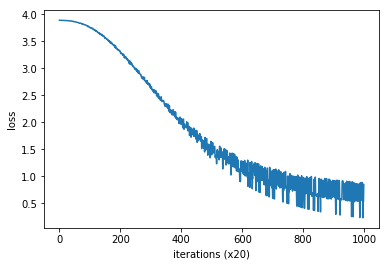

In [45]:
trainer.plot()

In [46]:
ssgs_model.predict(skipgram_contexts[4:6], id_to_word=id_to_word)

[word : say]
Upstream word: you
Downstream word: goodbye
[word : hello]
Upstream word: say
Downstream word: .


(array([[ 2.89059598, -1.54853449, -1.80098659, -1.80439621,  2.86159083,
         -0.27879951, -0.27945738],
        [-1.96280916,  3.37216741,  0.17847602,  0.21030826, -1.92692458,
         -0.94787063, -0.93990287]]),
 array([[-0.41725758, -1.89550212,  2.80121   , -0.61278156, -1.87908667,
          2.77248411, -1.83710724],
        [-0.74874506,  0.33370602, -1.86042419,  1.47375873,  0.3148882 ,
         -1.84025258,  3.67748904]]))

## Generating a Sentence

Notice the condition on the same word, for example word `say`.

In [47]:
down = convert_one_hot(np.array([word_to_id["say"]]), vocab_size=vocab_size)

In [48]:
for i in range(5):
    print(down.shape)    
    up, down = ssgs_model.predict(down, id_to_word=id_to_word, verbose=False)
    down = down.squeeze()
    idx = (-down).argsort()[0]
    down_word = id_to_word[idx]
    if down_word != '.':
        print(down_word)
    down = np.array([down])

(1, 7)
goodbye
(1, 7)
and
(1, 7)
i
(1, 7)
say
(1, 7)
goodbye
